In [53]:
# Import the required libraries
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, MaxPool2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import os
import PIL


In [2]:
# Mount the drive so that we can access files from the drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Path for train and test images

In [4]:
test_path = "/content/gdrive/MyDrive/SkinDataset/Test"

In [5]:
train_path = "/content/gdrive/MyDrive/SkinDataset/Train"

In [6]:
train_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

In [8]:
train_count = len(list(train_dir.glob('*/*.jpg')))
train_count

2239

In [9]:
test_count = len(list(test_dir.glob('*/*.jpg')))
test_count

118

# Splitting the dataset into training and validating dataset

### 80% of Training data set; 20% for validating the model

In [10]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, seed = 156, validation_split = 0.2,
                                                              image_size = (180, 180),
                                                              subset = 'training',
                                                              batch_size = 32,
                                                              color_mode = 'rgb')

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [11]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir, seed=156, validation_split=0.2,
                                                            image_size = (180, 180),
                                                            subset='validation',
                                                            batch_size = 32,
                                                            color_mode = 'rgb')

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Data Visualisation

In [12]:
class_names = train_dataset.class_names
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [13]:
image = plt.imread((list(train_dir.glob(class_names[6] + '/*.jpg'))[0]))

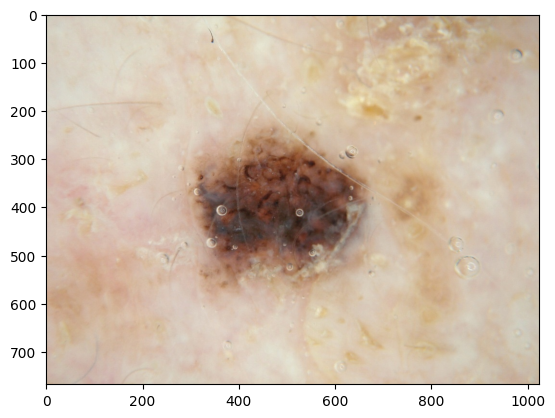

In [14]:
plt.imshow(image)

### Visualising one instance of all classes present in the dataset


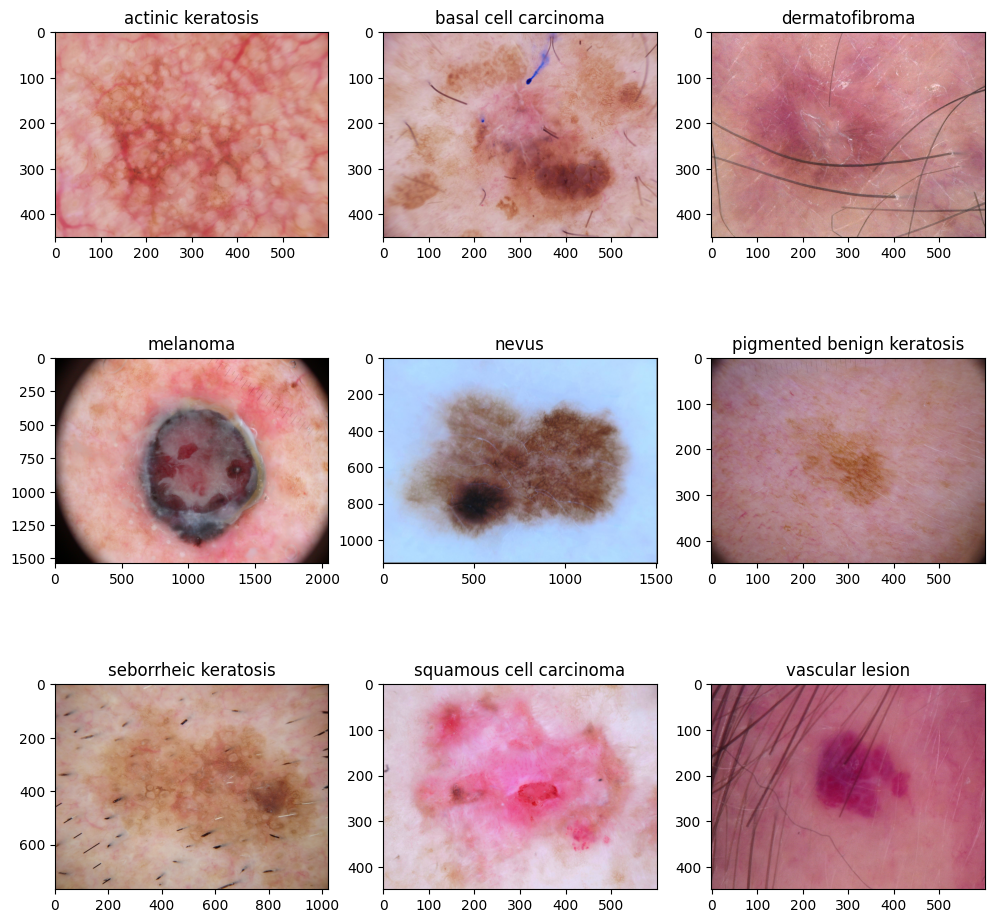

In [15]:
plt.figure(figsize=(12,12))
for i in range(9):
  plt.subplot(3, 3, i+1)
  image= plt.imread(str(list(train_dir.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

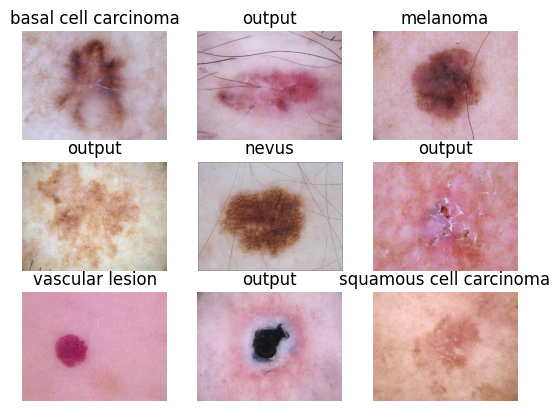

In [16]:
i = 0
for dirpath, dirnames, filenames in os.walk(str(train_path)):
  for filename in [name for name in filenames if name.endswith(".jpg")][:1]:
    if i <= 8:
      img = PIL.Image.open(str(dirpath) + "/" + str(filename))
      plt.subplot(3, 3, i + 1)
      plt.title(str(dirpath).split('/')[-1])
      plt.axis('off')
      plt.imshow(img)
      i = i + 1

cache() helps to keep the images in disk after loaded off for the first epoch.

prefetch() helps to parralelise data preprocessing and mode execution which training

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building

## The Model

The network receives an input in the form of a (180, 180, 3) dimension image.
The initial two layers consist of 32 channels with a filter size of 3*3 and employ the same padding.
Following this, there is a max pool layer with a stride of (2, 2).
ReLU serves as the activation function for all hidden layers, chosen for its computational efficiency.
Subsequently, the output is flattened, and a fully connected layer is introduced, facilitating the application of the softmax function for the classification of 9 classes.
To mitigate overfitting, a dropout rate of 0.2 is incorporated.

In [18]:
model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(180, 180, 3),
                                                                       offset=0.0)])

model.add(Conv2D(filters=32, kernel_size= (3,3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9, activation='softmax'))


## Compile Model

In [19]:
model.compile(optimizer = 'adam', metrics=['accuracy'],
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 32)        9248      
                                                        

We have
- Total params: 1,067,337
- Trainable params: 1,067,337
- Non-trainable params: 0

## Training Model

In [22]:
epochs= 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/20
169/169 [==============================] - 397s 2s/step - loss: 2.0543 - accuracy: 0.1931 - val_loss: 1.8370 - val_accuracy: 0.3304
Epoch 2/20
169/169 [==============================] - 13s 74ms/step - loss: 1.6477 - accuracy: 0.3718 - val_loss: 1.5841 - val_accuracy: 0.4046
Epoch 3/20
169/169 [==============================] - 13s 75ms/step - loss: 1.4824 - accuracy: 0.4193 - val_loss: 1.5582 - val_accuracy: 0.4135
Epoch 4/20
169/169 [==============================] - 13s 75ms/step - loss: 1.3915 - accuracy: 0.4557 - val_loss: 1.3237 - val_accuracy: 0.4781
Epoch 5/20
169/169 [==============================] - 13s 75ms/step - loss: 1.2817 - accuracy: 0.5067 - val_loss: 1.1856 - val_accuracy: 0.5434
Epoch 6/20
169/169 [==============================] - 13s 74ms/step - loss: 1.1804 - accuracy: 0.5421 - val_loss: 1.1533 - val_accuracy: 0.5932
Epoch 7/20
169/169 [==============================] - 13s 74ms/step - loss: 1.0362 - accuracy: 0.5992 - val_loss: 1.0511 - val_accuracy: 

## Visualising Results

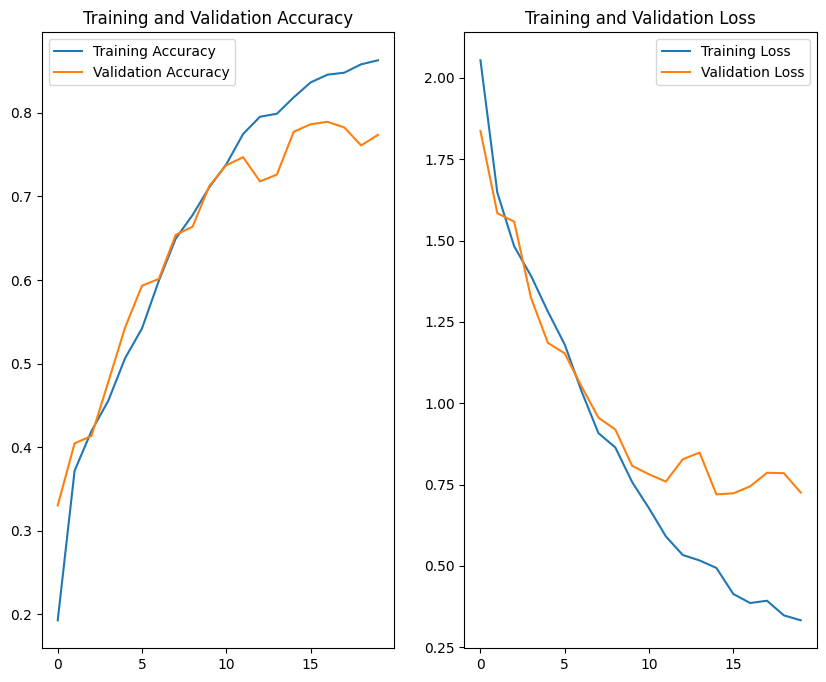

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Key Observations
Training accuracy hovers at approximately 85%.
Validation accuracy, currently around 81%, is declining, indicating potential overfitting.
The model exhibits overfitting, evident from the substantial gap between Training and Validation Accuracy.
With each epoch, Training Accuracy rises, but Validation Accuracy remains relatively stable and eventually decreases.
Until around 10 epochs, Validation Loss and Training Loss mirror each other. Afterward, Validation Loss increases while Training Loss continues to decrease, a typical behavior as the model refines.




In [24]:
# Lets check how images are distributed in different classed in training dataset
for i in range(len(class_names)):
  class_name = class_names[i]
  count = str(len(list(train_dir.glob(class_names[i] + '/*.jpg'))))
  print(class_name + " - " + count)


actinic keratosis - 114
basal cell carcinoma - 376
dermatofibroma - 95
melanoma - 438
nevus - 357
pigmented benign keratosis - 462
seborrheic keratosis - 77
squamous cell carcinoma - 181
vascular lesion - 139


In [25]:
# Lets check how images are distributed in different classed in test dataset
for i in range(len(class_names)):
  class_name= class_names[i]
  count = str(len(list(test_dir.glob(class_names[i]+'/*.jpg'))))
  print(class_name + " - " + count)


actinic keratosis - 16
basal cell carcinoma - 16
dermatofibroma - 16
melanoma - 16
nevus - 16
pigmented benign keratosis - 16
seborrheic keratosis - 3
squamous cell carcinoma - 16
vascular lesion - 3


## Potential Problems


Imbalanced dataset: The distribution of images in the training dataset is uneven.

Seborrheic keratosis: 77 samples
Squamous cell carcinoma: 181 samples
Vascular lesion: 139 samples
Actinic keratosis: 114 samples
The number of samples in the mentioned cases is significantly lower compared to others. To address this imbalance, we aim to increase the samples in each of the mentioned cases.

Our approach involves utilizing Data Augmentation and Augmentor techniques.


# Data Augmentation

In [26]:
data_augmentation = tf.keras.Sequential([
                                          layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical"),
                                          layers.experimental.preprocessing.RandomRotation(0.2)
])

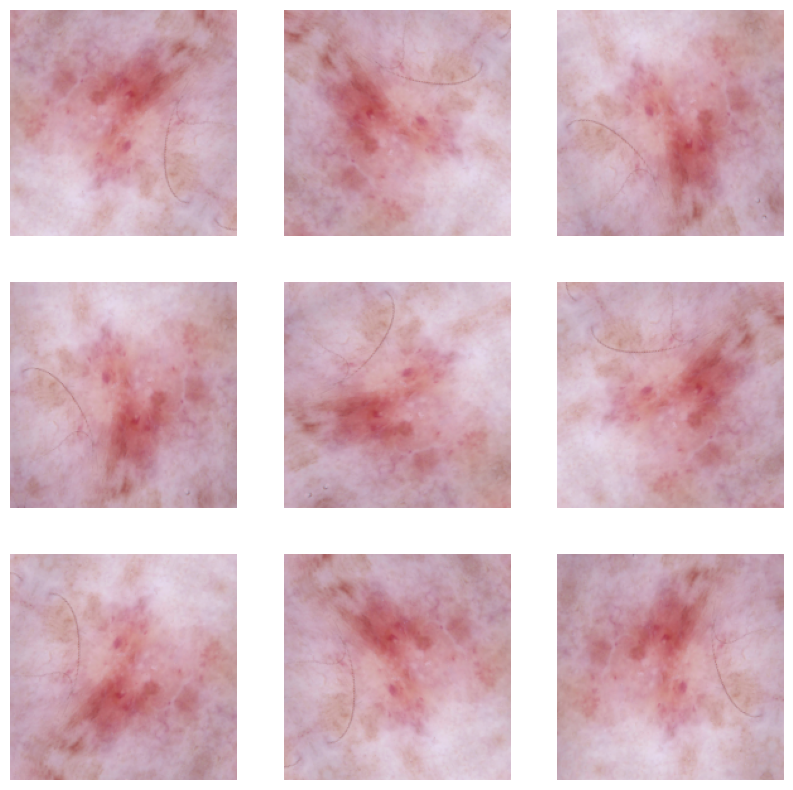

In [27]:
image, label = next(iter(train_ds))
image = np.array(image ,np.int32)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)
  plt.imshow((augmented_image1))
  plt.axis("off")

## Model with Data Augumentation

In [28]:
model=Sequential([data_augmentation,
                  tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape=(180, 180, 3), offset=0.0)])

model.add(Conv2D(filters=32, kernel_size= (3,3), activation='relu', padding='same', input_shape=(180, 180, 3)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(9, activation='softmax'))

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 17s 82ms/step - loss: 2.0492 - accuracy: 0.1964 - val_loss: 1.8391 - val_accuracy: 0.2650
Epoch 2/20
169/169 [==============================] - 14s 81ms/step - loss: 1.7389 - accuracy: 0.3218 - val_loss: 1.6698 - val_accuracy: 0.3578
Epoch 3/20
169/169 [==============================] - 13s 79ms/step - loss: 1.5777 - accuracy: 0.3922 - val_loss: 1.7697 - val_accuracy: 0.3326
Epoch 4/20
169/169 [==============================] - 13s 78ms/step - loss: 1.5367 - accuracy: 0.4047 - val_loss: 1.5269 - val_accuracy: 0.4098
Epoch 5/20
169/169 [==============================] - 13s 78ms/step - loss: 1.4733 - accuracy: 0.4345 - val_loss: 1.5312 - val_accuracy: 0.4239
Epoch 6/20
169/169 [==============================] - 13s 79ms/step - loss: 1.4276 - accuracy: 0.4360 - val_loss: 1.5636 - val_accuracy: 0.3875
Epoch 7/20
169/169 [==============================] - 13s 79ms/step - loss: 1.4164 - accuracy: 0.4449 - val_loss: 1.4075 - val_accuracy:

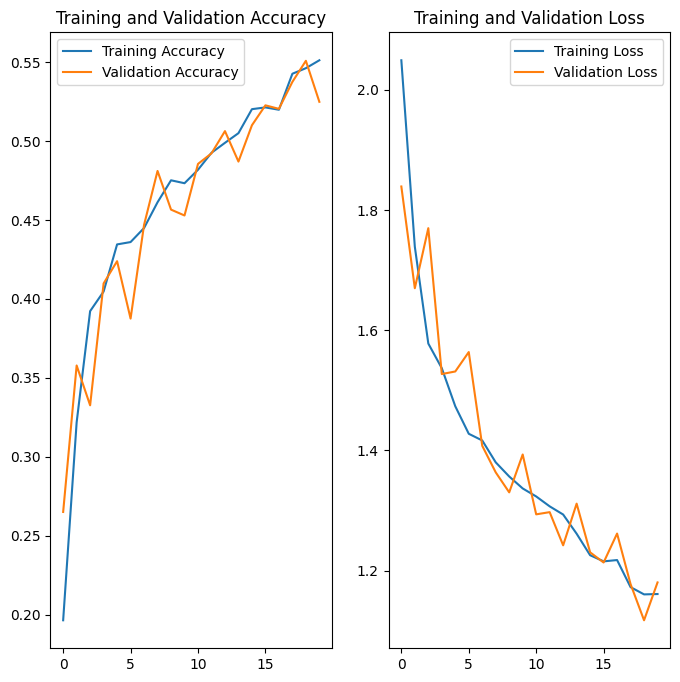

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc ='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc ='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Key Observations
Training accuracy and validation accuracy exhibit nearly identical trends at present.

Despite the fact that training and testing accuracy are now nearly equivalent, the issue of overfitting has been mitigated through the implementation of data augmentation. As a result, both accuracies are converging.

Our current challenge lies in addressing reduced accuracies.




# Checking for Class Imbalance

In [32]:
# Lets check how images are distributed in different classed in test dataset
for i in range(len(class_names)):
  class_name= class_names[i]
  count = str(len(list(train_dir.glob(class_names[i]+'/*.jpg'))))
  print(class_name +" - "+ count)


actinic keratosis - 114
basal cell carcinoma - 376
dermatofibroma - 95
melanoma - 438
nevus - 357
pigmented benign keratosis - 462
seborrheic keratosis - 77
squamous cell carcinoma - 181
vascular lesion - 139


The training dataset the distribution of images are uneven.


- seborrheic keratosis - 77
- squamous cell carcinoma - 181
- vascular lesion - 139
- actinic keratosis - 114


The samples in above cases are very less in comparison to
the other cases. So we need to increase the samples in each case.

###  Augmentor for addressing class imbalance problem

In [34]:
!pip install Augmentor

In [35]:
import Augmentor

In [36]:
for i in class_names:
  print(train_path + i)

/content/gdrive/MyDrive/SkinDataset/Trainactinic keratosis
/content/gdrive/MyDrive/SkinDataset/Trainbasal cell carcinoma
/content/gdrive/MyDrive/SkinDataset/Traindermatofibroma
/content/gdrive/MyDrive/SkinDataset/Trainmelanoma
/content/gdrive/MyDrive/SkinDataset/Trainnevus
/content/gdrive/MyDrive/SkinDataset/Trainpigmented benign keratosis
/content/gdrive/MyDrive/SkinDataset/Trainseborrheic keratosis
/content/gdrive/MyDrive/SkinDataset/Trainsquamous cell carcinoma
/content/gdrive/MyDrive/SkinDataset/Trainvascular lesion


In [37]:

training_dataset_path = train_path
for i in class_names:
    p = Augmentor.Pipeline(training_dataset_path + '/' +i)
    p.rotate(probability = 0.7, max_right_rotation = 10, max_left_rotation = 10)
    p.sample(500)
# We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinDataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790260437BE0>: 100%|██████████| 500/500 [00:20<00:00, 24.38 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinDataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790260607C40>: 100%|██████████| 500/500 [00:22<00:00, 22.44 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinDataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x790260555930>: 100%|██████████| 500/500 [00:18<00:00, 26.45 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinDataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7902605079A0>: 100%|██████████| 500/500 [01:17<00:00,  6.43 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinDataset/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x79028B94C4F0>: 100%|██████████| 500/500 [01:20<00:00,  6.20 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinDataset/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7902602F3B20>: 100%|██████████| 500/500 [00:17<00:00, 28.07 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinDataset/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x790268FD9BD0>: 100%|██████████| 500/500 [00:39<00:00, 12.61 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinDataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79028B935E70>: 100%|██████████| 500/500 [00:16<00:00, 29.73 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/SkinDataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7902D0238DC0>: 100%|██████████| 500/500 [00:17<00:00, 28.64 Samples/s]


In [38]:
from glob import glob

In [39]:
path_list = [x for x in glob(os.path.join(train_dir, '*','output', '*.jpg'))]

In [40]:
len(path_list)

9000

In [41]:
list_new = [os.path.basename(os.path.dirname(os.path.dirname(dir))) for dir in glob(os.path.join(train_dir, '*','output', '*.jpg'))]

In [42]:
len(list_new)

9000

In [43]:
new_dataframe_dict = dict(zip(path_list, list_new))


In [44]:
len(new_dataframe_dict )

9000

In [45]:
for i in class_names:
    directory = train_path
    directory_out = train_path + '/' + i +'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length = len(list(class_directory.glob(i + '/*.jpg')))
    length_out = len(list(class_directory_out.glob('*.jpg')))
    length_total = length + length_out
    print(f'{i} has {length_total} samples.')

actinic keratosis has 1114 samples.
basal cell carcinoma has 1376 samples.
dermatofibroma has 1095 samples.
melanoma has 1438 samples.
nevus has 1357 samples.
pigmented benign keratosis has 1462 samples.
seborrheic keratosis has 1077 samples.
squamous cell carcinoma has 1181 samples.
vascular lesion has 1139 samples.


### By augmentor the number of sampes in each class has been increased. Now the distribution looks balanced.

# **Model with Augmented Data**

In [46]:
img_height = 180
img_width = 180

In [47]:
data_dir_train=train_path
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed = 156, label_mode='categorical', validation_split = 0.2,
                                                               subset = 'training', image_size = (img_height, img_width), batch_size=32)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


In [48]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, seed = 156, label_mode='categorical', validation_split = 0.2,
                                                                  subset = 'validation', image_size=(img_height, img_width), batch_size=32)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


In [49]:
model=Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1/255,
                                                                       input_shape = (180, 180 ,3),
                                                                       offset = 0.0)])

model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = (180, 180, 3)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 32,kernel_size = (3,3),activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64,kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size =( 2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(9, activation = 'softmax'))


In [50]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
tf.config.run_functions_eagerly(True)
history = model.fit(train_dataset, validation_data = val_dataset, epochs=25)

Epoch 1/25
281/281 [==============================] - 77s 254ms/step - loss: 1.9152 - accuracy: 0.2518 - val_loss: 1.6775 - val_accuracy: 0.3761
Epoch 2/25
281/281 [==============================] - 62s 217ms/step - loss: 1.4879 - accuracy: 0.4223 - val_loss: 1.3012 - val_accuracy: 0.5029
Epoch 3/25
281/281 [==============================] - 61s 214ms/step - loss: 1.2712 - accuracy: 0.5111 - val_loss: 1.1494 - val_accuracy: 0.5616
Epoch 4/25
281/281 [==============================] - 63s 221ms/step - loss: 1.0919 - accuracy: 0.5834 - val_loss: 1.0971 - val_accuracy: 0.5888
Epoch 5/25
281/281 [==============================] - 60s 210ms/step - loss: 0.9380 - accuracy: 0.6501 - val_loss: 0.8757 - val_accuracy: 0.6684
Epoch 6/25
281/281 [==============================] - 60s 208ms/step - loss: 0.8310 - accuracy: 0.6895 - val_loss: 0.7590 - val_accuracy: 0.7352
Epoch 7/25
281/281 [==============================] - 62s 218ms/step - loss: 0.7037 - accuracy: 0.7319 - val_loss: 0.7373 - val_ac

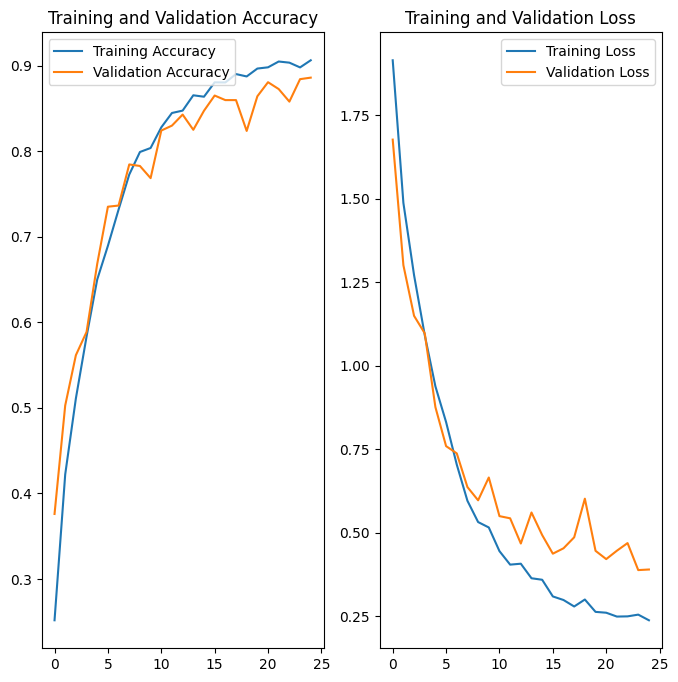

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=25
epochs_range =range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Conclusion
The test set accuracy stands at approximately 90%.
The validation dataset accuracy is recorded at around 87%.
Running additional epochs might improve model performance, but it also raises concerns about potential overfitting.
The model, exhibiting the mentioned accuracy, demonstrates enhanced performance when trained on a dataset with balanced class images.
Performance improvement is noticeable when the model is trained on augmented data.
There is minimal disparity between training loss and validation loss, with both following a similar trend.